In [1]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize
from gensim import corpora, models
import gensim
import nltk
import pandas as pd
import numpy as np
import re
import random
import matplotlib.pyplot as plt
import pyLDAvis.gensim as gensimvis
import pyLDAvis
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Load Data

In [2]:
articles = pd.read_csv('./Data/New_Full-Economic-News-DFE-839861.csv')

In [3]:
articles.text.head()

0    NEW YORK -- Yields on most certificates of dep...
1    The Wall Street Journal Online</br></br>The Mo...
2    WASHINGTON -- In an effort to achieve banking ...
3    The statistics on the enormous costs of employ...
4    NEW YORK -- Indecision marked the dollar's ton...
Name: text, dtype: object

# Data Preprocessing 

In [4]:
#Text cleaning to remove numbers and special charaters

def Word_cleaning(entry):
    entry_low_case = entry.lower()
    
    #remove content before the first "--" and "</br></br>"
    for i in range(35):
        if ((entry_low_case[i:i+2] == '--') or (entry_low_case[i:i+10] == '</br></br>')):
            entry_low_case = entry_low_case[i:]
    
    #keep only words
    Only_words = re.sub('[^a-z]+', ' ', entry_low_case).strip()
    #words = Only_words.split()
    
    return(Only_words)

In [5]:
articles["Text_Clean"] = articles["text"].apply(lambda item: Word_cleaning(str(item)))

In [6]:
articles["Text_Clean"] 

0       yields on most certificates of deposit offered...
1       br br the morning brief a look at the day s bi...
2       in an effort to achieve banking reform senate ...
3       the statistics on the enormous costs of employ...
4       indecision marked the dollar s tone as traders...
5       stocks declined as investors weighed slower th...
6       royal bank of canada and bank of montreal post...
7       many people think that the monster of health c...
8       sequenom inc a genomics based biotechnology co...
9       the u s dollar declined against most major for...
10      br br a late pop by general motors kept the do...
11      mci worldcom inc fueled by growth in internet ...
12      br br the dreaded d word is back in circulatio...
13      commercial and industrial loan volume in the u...
14      a week before an international economic summit...
15      according to kevin a hassett and aparna mathur...
16      the long black braid the blinding white cotton...
17      the do

In [7]:
Clean_Text = articles["Text_Clean"].tolist()

In [8]:
# Lemmatization 
from nltk.corpus import wordnet
lemmatizer = WordNetLemmatizer()
Text_lemmatized = [[lemmatizer.lemmatize(word, wordnet.NOUN) for word in document.split()] for document in Clean_Text]

In [9]:
# Only keep nouns

Refined_Text=[]
for doc in Text_lemmatized:
    text_i=[]
    
    for i in nltk.pos_tag(doc):
        if i[1][0]=='N':
            text_i.append(i[0])
            
    Refined_Text.append(text_i)

In [33]:
# Word count

stopwords = nltk.corpus.stopwords.words('english')
word_count={}
len_filter = 2

for i in Refined_Text:
    for j in i:
        if (j not in stopwords) and (len(j)>len_filter):
            if j in word_count:
                word_count[j]+=1
            else:
                word_count[j]=1

In [330]:
# Show the top 50 words

from operator import itemgetter
W=sorted(word_count.items(), key=itemgetter(1))[::-1]
W[:50]

[('year', 10189),
 ('market', 8498),
 ('rate', 8151),
 ('stock', 7669),
 ('price', 5592),
 ('economy', 4097),
 ('interest', 3985),
 ('bank', 3978),
 ('month', 3794),
 ('company', 3762),
 ('week', 3526),
 ('percent', 3488),
 ('inflation', 3256),
 ('investor', 3048),
 ('time', 2988),
 ('point', 2952),
 ('government', 2831),
 ('dollar', 2818),
 ('president', 2806),
 ('tax', 2723),
 ('bond', 2690),
 ('yesterday', 2621),
 ('growth', 2581),
 ('day', 2567),
 ('reserve', 2463),
 ('share', 2454),
 ('fund', 2439),
 ('state', 2399),
 ('index', 2344),
 ('business', 2326),
 ('york', 2296),
 ('quarter', 2194),
 ('money', 2148),
 ('increase', 2106),
 ('job', 1984),
 ('consumer', 1929),
 ('fed', 1904),
 ('report', 1894),
 ('deficit', 1869),
 ('policy', 1855),
 ('sale', 1845),
 ('economist', 1805),
 ('trading', 1797),
 ('analyst', 1768),
 ('budget', 1751),
 ('term', 1750),
 ('today', 1713),
 ('people', 1699),
 ('security', 1646),
 ('dow', 1639),
 ('treasury', 1620)]

In [95]:
# List of superfluous words from the top 50 words

superfluous_words = ['day', 'today', 'yesterday', 'week', 'month', 'quarter', 'time', 'percent', 'rate', 
                     'point', 'economy', 'economist', 'growth', 'increase', 'average', 'york', 'report', 'analyst', 'term', 'people']

In [118]:
# Remove stop words and words with length less than 2

stopwords = nltk.corpus.stopwords.words('english')
len_filter = 2
Final_Text = [[word for word in document if (word not in stopwords) and (word not in superfluous_words) and (len(word)>len_filter)] 
              for document in Refined_Text]

In [120]:
# Make dictionary using the final words

dictionary = corpora.Dictionary(Final_Text)
print(dictionary)

Dictionary(21961 unique tokens: ['yield', 'certificate', 'deposit', 'bank', 'tenth']...)


In [121]:
# Filter out words appear in less 5 docs or more than half of all docs

dictionary.filter_extremes(no_below=5, no_above=0.5)
dictionary.compactify()
print(dictionary)

Dictionary(5293 unique tokens: ['yield', 'certificate', 'deposit', 'bank', 'tenth']...)


In [333]:
print(dictionary)

Dictionary(5293 unique tokens: ['yield', 'certificate', 'deposit', 'bank', 'tenth']...)


In [122]:
corpus = [dictionary.doc2bow(doc) for doc in Final_Text]

In [123]:
print(corpus[0])

[(0, 4), (1, 1), (2, 3), (3, 4), (4, 1), (5, 2), (6, 2), (7, 1), (8, 2), (9, 3), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1)]


In [124]:
corpora.MmCorpus.serialize('Economic_news_2.mm', corpus)

In [125]:
dictionary.save('Economic_news_2.dict')

# Load Saved Dictionary and Corpus

In [126]:
dictionary = corpora.dictionary.Dictionary.load('Economic_news_2.dict')
corpus = corpora.MmCorpus('Economic_news_2.mm')

In [127]:
print(dictionary)

Dictionary(5293 unique tokens: ['yield', 'certificate', 'deposit', 'bank', 'tenth']...)


In [128]:
print(corpus[0])

[(0, 4.0), (1, 1.0), (2, 3.0), (3, 4.0), (4, 1.0), (5, 2.0), (6, 2.0), (7, 1.0), (8, 2.0), (9, 3.0), (10, 2.0), (11, 1.0), (12, 1.0), (13, 1.0), (14, 1.0), (15, 1.0), (16, 1.0), (17, 1.0), (18, 1.0), (19, 1.0), (20, 1.0), (21, 1.0), (22, 1.0), (23, 1.0)]


In [129]:
len(corpus)

8000

# Tune LDA Hyperparameters

In [141]:
# Cadidates for number of topics

Topic_nums=range(1, 31, 1)

## Topic Coherence
## Umass 
Umass is based on document cooccurrence counts, a one-preceding segmentation and a logarithmic conditional probability as confirmation measure.

The main idea of this coherence is that the occurrence of every top word should be supported by every top preceding top word. Thus, the probability of a top word to occur should be higher if a document already contains a higher order top word of the same topic. Therefore, for every word the logarithm of its conditional probability is calculated using every other top word that has a higher order in the ranking of top words as condition. The probabilities are derived using document cooccurrence counts. The single conditional probabilities are summarized using the arithmetic mean.

In [161]:
#Initialize
Umass_100 = []
Umass_300 = []
Umass_500 = []

In [335]:
# Set up log to external log file
import logging
logging.basicConfig(filename='lda_umass.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Set up log to terminal
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [342]:
# Function to train LDA model using the topic coherence measure (either Umass or Cv)

def LDA_Tune(Iter, Topic_nums, coherence_option):
    result=[]
    print("Number of Iterations:", Iter)
    
    for j in Topic_nums:
        lda = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, iterations=Iter, num_topics=j, eval_every=None) 
        
        if coherence_option=='u_mass':
            cm = models.CoherenceModel(model=lda, corpus=corpus, dictionary=dictionary, coherence='u_mass')
            print("Num of Topics:", j, ",", cm.get_coherence())
            result.append(cm.get_coherence())
        
        elif coherence_option=='c_v':
            cm = models.CoherenceModel(model=lda, texts=Final_Text, dictionary=dictionary, coherence='c_v')  #need to use "texts" here
            print("Num of Topics:", j, ",", cm.get_coherence())
            result.append(cm.get_coherence())
    
    return(result)  

In [343]:
Umass_100=LDA_Tune(100, Topic_nums, 'u_mass')
Umass_300=LDA_Tune(300, Topic_nums, 'u_mass')
Umass_500=LDA_Tune(500, Topic_nums, 'u_mass')

Number of Iterations: 100
Num of Topics: 1 , -1.79540233156
Num of Topics: 2 , -1.71601501539
Num of Topics: 3 , -1.79129498196
Num of Topics: 4 , -1.82796312304
Num of Topics: 5 , -1.75295434002
Num of Topics: 6 , -1.85954537709
Num of Topics: 7 , -1.88013051883
Num of Topics: 8 , -1.90380875705
Num of Topics: 9 , -1.99212657508
Num of Topics: 10 , -1.98138859789
Num of Topics: 11 , -2.02914532636
Num of Topics: 12 , -2.01091852304
Num of Topics: 13 , -2.01932389033
Num of Topics: 14 , -2.05472670889
Num of Topics: 15 , -2.02838970941
Num of Topics: 16 , -2.13051953973
Num of Topics: 17 , -2.50723237354
Num of Topics: 18 , -2.19645284604
Num of Topics: 19 , -2.19113462868
Num of Topics: 20 , -2.34578174706
Num of Topics: 21 , -2.28237866605
Num of Topics: 22 , -2.26254555677
Num of Topics: 23 , -2.56019980342
Num of Topics: 24 , -2.63817976201
Num of Topics: 25 , -2.3439385782
Num of Topics: 26 , -2.59789297332
Num of Topics: 27 , -2.5583481092
Num of Topics: 28 , -2.43000633411
Num o

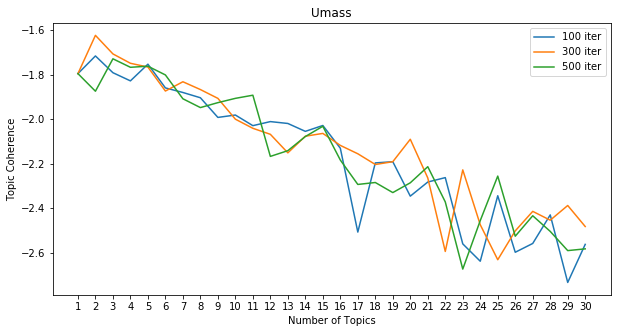

In [344]:
# Plot Umass

plt.figure(figsize=(10,5))
x = Topic_nums
plt.plot(x, Umass_100)
plt.plot(x, Umass_300)
plt.plot(x, Umass_500)
plt.xlabel("Number of Topics")
plt.ylabel("Topic Coherence")
plt.xticks(Topic_nums)
plt.legend(['100 iter','300 iter', '500 iter'], loc='upper right')
plt.title('Umass')
plt.show()

# Maximum obatined at (2,300)

In [345]:
# The optiamal model based on Umass (iterations=300, num_topics=)

lda_umass = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, iterations=300, num_topics=2, passes=20)

In [360]:
lda_umass.save('Economic_news_umass.model')

## Find the topic each article belongs to

In [432]:
# Show the top 10 words of each topic

for i in range(2):
    print("Topic:", i+1)
    for k in lda_umass.get_topic_terms(i):
        print(dictionary[k[0]])

Topic: 1
market
stock
price
interest
investor
company
bond
share
dollar
index
Topic: 2
tax
president
state
government
budget
job
house
deficit
bank
administration


In [433]:
# Function to assign each article to topic using the maximum topic probability

def Doc_membership(model):
    Assignment = []
    for i in range(len(corpus)):
        Doc_topic = sorted(model.get_document_topics(corpus[i]),key=itemgetter(1))
        Assignment.append((i+1, Doc_topic[-1][0]+1))   #need to "+1" since the indices start from 0
    return Assignment

In [434]:
# List of tuples (Document_id, topic_id)
Doc_assign_umass = Doc_membership(lda_umass)

# Dictionary of {Document: Topic_id}
Doc_Topic_umass = dict(Doc_assign_umass)

# Dictionary of {Topic_id: documents}
Topic_Doc_umass={}
for i in Doc_Topic_umass:
    value = Doc_Topic_umass.get(i)
    Topic_Doc_umass.setdefault(value,[]).append(i)  
    
# Dictionary of {Topic_id: number of documents}
Topic_count_umass={}
for key in Topic_Doc_umass:
    Topic_count_umass[key] = len(Topic_Doc_umass[key])
    
print(sorted(Topic_count_umass.items()))

[(1, 4363), (2, 3637)]


In [435]:
# The topic of article no.2587 (have changed the numbering to makeing it start from 1)
Doc_Topic_umass[2587]

1

In [436]:
# Show article no.2587's topic probabilites (2586 here as the numbering from the original model output starts from 0)
lda_umass.get_document_topics(corpus[2586])

[(0, 0.89447860574687577), (1, 0.10552139425312428)]

## C_v
C_v is based on a sliding window, a one-set segmentation of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosinus similarity.

This coherence measure retrieves cooccurrence counts for the given words using a sliding window and the window size 110. The counts are used to calculated the NPMI of every top word to every other top word, thus, resulting in a set of vectors—one for every top word. The one-set segmentation of the top words leads to the calculation of the similarity between every top word vector and the sum of all top word vectors. 

In [347]:
c_v_100 = []
c_v_300 = []
c_v_500 = []

In [356]:
c_v_100=LDA_Tune(100, Topic_nums, 'c_v')
c_v_300=LDA_Tune(300, Topic_nums, 'c_v')
c_v_500=LDA_Tune(500, Topic_nums, 'c_v')

Number of Iterations: 100
Num of Topics: 1 , 0.310186360254
Num of Topics: 2 , 0.477272517315
Num of Topics: 3 , 0.456534750011
Num of Topics: 4 , 0.515438066385
Num of Topics: 5 , 0.452755632087
Num of Topics: 6 , 0.430264449493
Num of Topics: 7 , 0.456699508253
Num of Topics: 8 , 0.44965611813
Num of Topics: 9 , 0.462520910355
Num of Topics: 10 , 0.479519159428
Num of Topics: 11 , 0.451149899471
Num of Topics: 12 , 0.515978372019
Num of Topics: 13 , 0.470650933659
Num of Topics: 14 , 0.482906222079
Num of Topics: 15 , 0.491099929241
Num of Topics: 16 , 0.450063886972
Num of Topics: 17 , 0.434721529178
Num of Topics: 18 , 0.45358902671
Num of Topics: 19 , 0.453731558979
Num of Topics: 20 , 0.463340529183
Num of Topics: 21 , 0.460739555347
Num of Topics: 22 , 0.432467552269
Num of Topics: 23 , 0.456536880301
Num of Topics: 24 , 0.459563559484
Num of Topics: 25 , 0.457389198834
Num of Topics: 26 , 0.454826748766
Num of Topics: 27 , 0.430075420248
Num of Topics: 28 , 0.431109988809
Num o

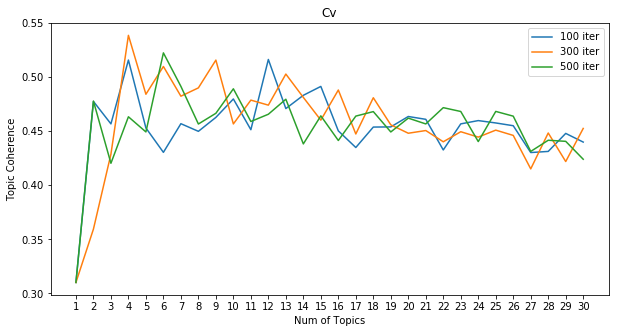

In [357]:
# Plot Cv

plt.figure(figsize=(10,5))
x = Topic_nums
plt.plot(x, c_v_100)
plt.plot(x, c_v_300)
plt.plot(x, c_v_500)
plt.xlabel("Num of Topics")
plt.ylabel("Topic Coherence")
plt.xticks(Topic_nums)
plt.legend(['100 iter','300 iter', '500 iter'], loc='upper right')
plt.title('Cv')
plt.show()

# Maximum obatined at (4,300)

In [358]:
# The optiamal model based on Cv (iterations=300, num_topics=4)

lda_cv = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, iterations=300, num_topics=4, passes=20)

In [361]:
lda_cv.save('Economic_news_cv.model')

## Find the topic each article belongs to

In [429]:
# Show the top words in each topic

for i in range(4):
    print("Topic:", i+1)
    for k in lda_cv.get_topic_terms(i):
        print(dictionary[k[0]])

Topic: 1
tax
state
president
job
budget
government
deficit
unemployment
house
administration
Topic: 2
stock
market
price
index
investor
dollar
trading
dow
bond
share
Topic: 3
company
sale
business
share
industry
firm
home
corp
service
inc
Topic: 4
bank
interest
reserve
fed
fund
loan
market
money
treasury
credit


In [430]:
#List of tuples (Document_id, topic_id)
Doc_assign_cv = Doc_membership(lda_cv)

#Dictionary of {Document: Topic_id}
Doc_Topic_cv = dict(Doc_assign_cv)

#Dictionary of {Topic_id: documents}
Topic_Doc_cv={}
for i in Doc_Topic_cv:
    value = Doc_Topic_cv.get(i)
    Topic_Doc_cv.setdefault(value,[]).append(i)  
    
#Dictionary of {Topic_id: number of documents}
Topic_count_cv={}
for key in Topic_Doc_cv:
    Topic_count_cv[key] = len(Topic_Doc_cv[key])
    
print(sorted(Topic_count_cv.items()))

[(1, 2573), (2, 2689), (3, 1358), (4, 1380)]


In [431]:
# The topic of article no.2587 (have changed the numbering to makeing it start from 1)
Doc_Topic_cv[2587]

2

In [438]:
# Show article no.2587's topic probabilites (2586 here as the numbering from the original model output starts from 0)
lda_cv.get_document_topics(corpus[2586])

[(0, 0.051153546538125517), (1, 0.52104933880707194), (3, 0.4237244740304878)]